## Day 13 - Backtest V2

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
"""
    :param ticker: closing prices
    :param start: history start date
    :param end: history end date
    :return: stock's historical data 
"""
def get_data(ticker,start="2018-03-25"):
    
    return yf.download(ticker, start)


"""
    :param close: closing prices
    :param length: moving average length
    :return: stock's exponential moving average (EMA)
    
"""
def get_EMA(close,length=20):
    return close.ewm(span=length, adjust=False).mean()

In [32]:
"""
    :param close: closing prices
    :param len_moving_average: moving average length
    :return buy: list with buy's signals (indexes)
    :return sell: list with sell's signals (indexes)
    :return df_signal_3: new dataframe that contains "close" and "ema(s)"
    :return balance: final balance after trading
"""
def trade_3(close, len_short_ma=20, len_long_ma=100, budget=10000):
    
    ma_short = get_EMA(close,length=len_short_ma)
    ma_long = get_EMA(close,length=len_long_ma)
    
    df_signal_3 = pd.DataFrame({'ma_short' : ma_short, 
                                'ma_long' : ma_long,
                                'close' : close}).dropna()
    
    buy = []
    sell = []
    
    # trade at most 30% of the total balance
    balance = budget 
    traded = 0
    traded_price = 0
    
    # pos = 0 : we do not have any position -> we can buy but we cannot sell
    # pos = 1 : we have a position -> we can sell and we cannot buy 
    
    # I am not considering trading fees
    # I suppose to trade the entire balance 
    pos = 0
    
    # update the profit every time I sell
    # I use another sell_list because I want to know also the final balance If it 
    # is still holding the last position
    sell_dates = []
    profit_values = []
    
    for i in range(len(df_signal_3)-1):
        
        if df_signal_3.ma_short.iloc[i-1] < df_signal_3.ma_long.iloc[i] \
        and df_signal_3.ma_short.iloc[i+1] > df_signal_3.ma_long.iloc[i] \
        and pos == 0:
            buy.append(i)
            pos = 1
            
            # update balance
            traded_price = df_signal_3.close[i]
            traded = balance
            balance = 0
            
        
        if df_signal_3.ma_short.iloc[i-1] > df_signal_3.ma_long.iloc[i] \
        and df_signal_3.ma_short.iloc[i+1] < df_signal_3.ma_long.iloc[i] \
        and pos == 1:
            sell.append(i)
            pos = 0
            
            # update balance
            balance += traded * (df_signal_3.close[i]/traded_price)
            
            # update profit
            sell_dates.append(i)
            profit_values.append(balance-budget)
        
    # final price
    if pos == 1:
        balance += traded * (df_signal_3.close[len(df_signal_3)-1]/traded_price)
        
        # update profit
        sell_dates.append(len(df_signal_3)-1)
        profit_values.append(balance-budget)
    
    return buy, sell, df_signal_3, balance, sell_dates, profit_values

[*********************100%***********************]  1 of 1 completed


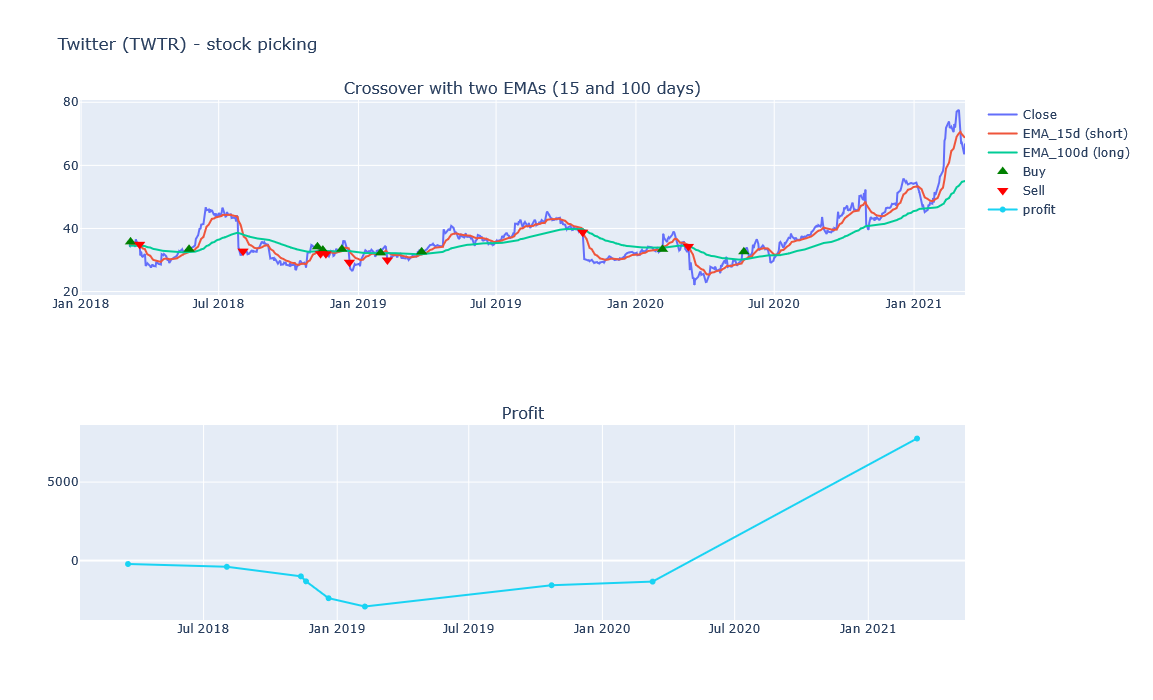

Traded 		: 10000
Balance 	: 17776.00
Net 		: 7776.00


In [52]:
trade = 10000

stock_history_3  = get_data('TWTR','2018-03-06')
stock_history_3 = stock_history_3['Adj Close']
buy_3, sell_3, df_signal_3, balance_3, sell_dates, profit_values = trade_3(stock_history_3, 15, 100, trade)



fig = make_subplots(rows=2, cols=1, subplot_titles=("Crossover with two EMAs (15 and 100 days)", "Profit"))

fig.add_trace(go.Scatter(x=df_signal_3.index, y=df_signal_3['close'], name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_signal_3.index, y=df_signal_3['ma_short'], name='EMA_15d (short)'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_signal_3.index, y=df_signal_3['ma_long'], name='EMA_100d (long)'), row=1, col=1)


fig.add_trace(go.Scatter(x=df_signal_3.iloc[buy_3].index, y=df_signal_3.iloc[buy_3]['close'], name='Buy',
                          mode='markers', marker=dict(color='green', size=10, symbol='triangle-up')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df_signal_3.iloc[sell_3].index, y=df_signal_3.iloc[sell_3]['close'], name='Sell',
                          mode='markers', marker=dict(color='red', size=10, symbol='triangle-down')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_signal_3.iloc[sell_dates].index, y=profit_values, name='profit'),row=2, col=1)

fig.update_layout(title_text="Twitter (TWTR) - stock picking",height=700)
fig.show()

# static rendering for github
# fig.show("svg")

print(f"Traded \t\t: {trade}")
print(f"Balance \t: {balance_3:.2f}")
print(f"Net \t\t: {balance_3 - trade :.2f}")